# Нужно с помощью reinforcement learning и стратегии актор-критик обучить модель играть в игру BipedalWalker-v2

В работе использовал как бейзлайны решения различных задач
    - https://github.com/zsdonghao/tensorlayer/tree/master/example
    - https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow/tree/master/experiments
    - https://github.com/topics/actor-critic
    - https://github.com/rlcode/reinforcement-learning/
    

Первым шагом, я пытался как-то приспособить agentnet a2c для недискретных действий, 




In [22]:
# написал свой resolver

class ProbabilisticResolver(BaseResolver):

    def __init__(self, incoming, assume_normalized=False, seed=1234, output_dtype='int32',
                 name='ProbabilisticResolver'):
        self.assume_normalized = assume_normalized
        self.rng = random_streams.RandomStreams(seed)
        super(ProbabilisticResolver, self).__init__(incoming, name=name,output_dtype=output_dtype)

    def get_output_for(self, policy, greedy=False, **kwargs):
        #print(dir(policy))
        #print(policy.shape)
        if greedy:
            chosen_action_ids = policy
        else:
            batch_size, n_actions = policy.shape
            print(batch_size, n_actions)
            chosen_action_ids = (policy + self.rng.normal(size=policy.shape))
            #chosen_action_ids = T.min(chosen_action_ids, T.ones_like(chosen_action_ids))
            #chosen_action_ids = T.max(chosen_action_ids, -T.ones_like(chosen_action_ids))

        return chosen_action_ids


action_layer = ProbabilisticResolver(policy_layer,
                                     name="e-greedy action picker",
                                     assume_normalized=True)

NameError: name 'BaseResolver' is not defined

но ничего не получилось, там где-то в глубине EnvPool update непонятные проверки на размерность 
https://github.com/yandexdataschool/AgentNet/blob/master/agentnet/learning/a2c.py

то что получилось лежит в agentnetTry.ipynb

# Попытка 2

Попытался написать все без фреймворков, вручную. Но обучение почему-то не шло.

Написал еще одного критика, который будет предсказывать параметры ошибки предсказаний актора (дисперсию для шума, который будем прибавлять к предсказаниям)

(Изначально параметры ошибки у меня предсказывал актор, но я решил попробовать попредсказывать их отдельным критиком)

Пытался по разному играть с наградой, так как часто оптимальной стратегией было просто встать на ноги и не двигаться (это логично следует из награды).

Пытался уменьшать штраф за падения

Пытался обнулять мелкие отрицательные награды

Пытался увеличивать поощрение за текущую позицию шагальщика

In [ ]:
# код 2 попытки

import threading
import numpy as np
import tensorflow as tf
import pylab
import time
import gym
from keras.layers import Dense, Concatenate, Input, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K


K.set_learning_phase(1)

make_env = lambda: gym.make('BipedalWalker-v2')

episode = 0
scores = []
finalPositions = []

EPISODES = 50000

class A3CAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        self.actor_lr = 0.003
        self.critic_lr = 0.003
        self.critic_var_lr = 0.003
        self.discount_factor = .9
        self.hidden1, self.hidden2 = 48, 48
        self.threads = 4

        self.actor, self.critic, self.critic_var = self.build_model()

        self.optimizer = [self.actor_optimizer(), self.critic_optimizer(), self.critic_var_optimizer()]

        self.sess = tf.InteractiveSession()
        K.set_session(self.sess)
        self.sess.run(tf.global_variables_initializer())


    def build_model(self):
        state = Input(batch_shape=(None,  self.state_size))
        actor_first = Dense(self.hidden1, input_dim=self.state_size, activation='relu', kernel_initializer='glorot_uniform')(state)

        actor_hidden = Dense(self.hidden2, activation='tanh', kernel_initializer='glorot_uniform')(actor_first)
        #actor_hidden = Dropout(0.1)(actor_hidden)
        #actor_hidden = Dense(self.hidden2, activation='relu', kernel_initializer='glorot_uniform')(actor_hidden)
        #actor_hidden = Dropout(0.3)(actor_hidden)
        actor_hidden = Dense(self.hidden2, activation='relu', kernel_initializer='glorot_uniform')(actor_hidden)
        action_preoutput = Dense(self.action_size * 2, activation='tanh', kernel_initializer='glorot_uniform')(actor_hidden)
        #action_preoutput = Dense(self.action_size * 2, activation='relu', kernel_initializer='glorot_uniform')(shared)
        action_mean = Dense(self.action_size, activation='softsign', kernel_initializer='zeros')(action_preoutput)

        action_var_first = Dense(self.hidden1, input_dim=self.state_size, activation='relu', kernel_initializer='glorot_uniform')(state)

        action_var_hidden = Dense(self.hidden2, activation='tanh', kernel_initializer='glorot_uniform')(action_var_first)
        action_var_hidden = Dense(self.hidden2, activation='relu', kernel_initializer='glorot_uniform')(action_var_hidden)
        action_var_preoutput = Dense(self.action_size * 2, activation='tanh', kernel_initializer='glorot_uniform')(action_var_hidden)
        action_variance = Dense(self.action_size, activation='softplus', bias_initializer='ones')(action_preoutput)

        critic_first = Dense(self.hidden1, input_dim=self.state_size, activation='relu', kernel_initializer='glorot_uniform')(state)
        value_hidden = Dense(self.hidden2, activation='relu', kernel_initializer='uniform')(critic_first)
        state_value = Dense(1, activation='linear', kernel_initializer='zeros')(value_hidden)

        actor = Model(inputs=state, outputs=action_mean)
        critic = Model(inputs=state, outputs=state_value)
        critic_var = Model(inputs=state, outputs=action_variance)

        actor._make_predict_function()
        critic._make_predict_function()
        critic_var._make_predict_function()

        actor.summary()
        critic.summary()
        critic_var.summary()

        return actor, critic, critic_var

    def actor_optimizer(self):
        action = K.placeholder(shape=(None, self.action_size))
        action_var = K.stop_gradient(K.placeholder(shape=(None, self.action_size)))
        advantages = K.stop_gradient(K.placeholder(shape=(None, )))


        policy = self.actor.output

        good_prob = K.sum(((action - policy) / (action_var + 1e-9)) ** 2 + K.log(action_var + 1e-9), axis=1)
        #good_prob = -K.sum(-2 * ((action - policy[:, :self.action_size]) / (policy[:, self.action_size:] + 1e-9)) - K.log(policy[:, self.action_size:] + 1e-9), axis=1)

        #good_prob = K.sum(action * policy, axis=1)
        #eligibility = K.log(good_prob + 1e-10) * K.stop_gradient(advantages)
        #eligibility = good_prob * K.stop_gradient(advantages)
        eligibility = good_prob * advantages
        #eligibility = -K.stop_gradient(advantages)
        loss = K.sum(eligibility)

        entropy = K.sum((policy ** 2) * K.log((policy ** 2) + 1e-10), axis=1)

        actor_loss = loss + 0.01 * entropy
        #actor_loss = K.sum((action - policy[:, :self.action_size]))# / (policy[:, self.action_size:] + 1e-9)) + K.sum(K.log(policy[:, self.action_size:] + 1e10))

        optimizer = Adam(lr=self.actor_lr)
        updates = optimizer.get_updates(self.actor.trainable_weights, [], actor_loss)
        train = K.function([self.actor.input, action, action_var, advantages], [], updates=updates)
        return train

    def critic_var_optimizer(self):
        action = K.stop_gradient(K.placeholder(shape=(None, self.action_size)))
        advantages = K.stop_gradient(K.placeholder(shape=(None, )))
        policy = K.stop_gradient(K.placeholder(shape=(None, self.action_size)))
        action_var = self.critic_var.output

        loss = (K.sum(0.8 * (action - policy) ** 2 - action_var ** 2, axis=1) * advantages) / K.sum(advantages)

        entropy = K.sum(action_var * K.log(action_var + 1e-10), axis=1)

        critic_var_loss = loss + 0.01 * entropy

        optimizer = Adam(lr=self.critic_var_lr)
        updates = optimizer.get_updates(self.critic_var.trainable_weights, [], critic_var_loss)
        train = K.function([self.critic_var.input, action, policy, advantages], [], updates=updates)
        return train

    def critic_optimizer(self):
        discounted_reward = K.placeholder(shape=(None, ))

        value = self.critic.output

        loss = K.mean(K.square(discounted_reward - value))

        optimizer = Adam(lr=self.critic_lr)
        updates = optimizer.get_updates(self.critic.trainable_weights, [], loss)
        train = K.function([self.critic.input, discounted_reward], [], updates=updates)
        return train

    def train(self):
        # self.load_model('./save_model/cartpole_a3c.h5')
        agents = [Agent(i, self.actor, self.critic, self.critic_var, self.optimizer, self.discount_factor,
                        self.action_size, self.state_size) for i in range(self.threads)]

        for agent in agents:
            agent.start()

        global episode
        env = make_env()
        lep = 0
        while episode < EPISODES:
            #time.sleep(2)
            if lep + 50 < episode:
                lep = episode
                plot = scores[:]
                fig = pylab.figure(figsize=(20, 20))
                pylab.plot(range(len(plot)), plot, 'b')
                pylab.savefig("./save_graph/scores.png")
                del fig
                del plot
                plot = finalPositions[:]
                fig = pylab.figure(figsize=(20, 20))
                pylab.plot(range(len(plot)), plot, 'b')
                pylab.savefig("./save_graph/final_positions.png")
                del fig
                del plot

                self.save_model('./save_model/cartpole_a3c.h5')



            state = env.reset()
            for i in range(1600):
                action = agents[0].get_action(state)
                next_state, reward, done, _ = env.step(action)
                if i % 10 == 0:
                    env.render()
                if done:
                    break

        del env


        for agent in agents:
            agent.join()

    def save_model(self, name):
        self.actor.save_weights(name + "_actor.h5")
        self.critic.save_weights(name + "_critic.h5")

    def load_model(self, name):
        self.actor.load_weights(name + "_actor.h5")
        self.critic.load_weights(name + "_critic.h5")

class Agent(threading.Thread):
    def __init__(self, index, actor, critic, critic_var, optimizer, discount_factor, action_size, state_size):
        threading.Thread.__init__(self)

        self.states = []
        self.rewards = []
        self.actions = []
        self.positions = []

        self.index = index
        self.actor = actor
        self.critic = critic
        self.critic_var = critic_var
        self.optimizer = optimizer
        self.discount_factor = discount_factor
        self.action_size = action_size
        self.state_size = state_size

    def run(self):
        global episode
        env = make_env()
        max_pos = 0
        while episode < EPISODES:
            self.random_bias_rate = 1 # max(0.05, 0.7 * np.exp(-episode / 400))
            state = env.reset()
            score = 0
            steps = 0
            position = 0
            while True:
                action = self.get_action(state)
                next_state, reward, done, _ = env.step(action)
                newPosition = env.unwrapped.hull.position[0]
                max_pos = max(max_pos, position)
                #reward += position / (steps + 1)


                #print(reward)

                if 0 > reward and reward > -1:
                    reward = 0

                if reward == -100:
                    reward /= (1 + position) ** 2

                if newPosition < position:
                    reward += (newPosition - position) * 10

                #if done and position + 3 < max_pos:
                #    reward -= 100

                score += reward
                steps += 1

                self.memory(state, position, action, reward)

                state = next_state
                position = newPosition

                #if steps > 400 and steps % 101 == 0 and position > 0 and steps / position > 50:
                #    self.random_bias_rate *= 1.1
                    #~ donrue
                #if steps > 200 and episode < 1000:
                #    done = True

                if done:
                    episode += 1
                    print("episode: %4d" % episode, "/ random bias rate: %0.2f " % self.random_bias_rate,
                          "steps: %4d " % steps, " position: %2.3f " % position, "/ score: %0.3f " % score)
                    #~ print(self.states)
                    #~ print(self.actions)
                    #~ print(self.rewards)
                    scores.append(score)
                    finalPositions.append(position)
                    self.train_episode(score != 500)

                    break

    # In Policy Gradient, Q function is not available.
    # Instead agent uses sample returns for evaluating policy
    def discount_rewards(self, rewards, done=True):
        discounted_rewards = np.zeros_like(rewards)
        running_add = 0
        if not done:
            running_add = self.critic.predict(np.reshape(self.states[-1], (1, self.state_size)))[0]
        for t in reversed(range(0, len(rewards))):
            running_add = running_add * self.discount_factor + rewards[t]
            posAdvantage = 0
            #~ if len(rewards) > 300 and t + 100 < len(rewards):
                #~ posAdvantage = 100 * self.positions[-100] / (len(rewards) - 100)
            #~ if t + 100 > len(rewards):
                #~ posAdvantage -= 10
            discounted_rewards[t] = running_add + posAdvantage
        return discounted_rewards

    def memory(self, state, position, action, reward):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.positions.append(position)

    def train_episode(self, done):
        discounted_rewards = self.discount_rewards(self.rewards, done)

        values = self.critic.predict(np.array(self.states))
        values = np.reshape(values, len(values))
        policy = self.actor.predict(np.array(self.states))
        #policy = np.reshape(policy, (-1, len(policy)))
        actions_var = self.critic_var.predict(np.array(self.states))
        #actions_var = np.reshape(actions_var, len(actions_var))


        advantages = discounted_rewards - values

        def softmax(x):
            """Compute softmax values for each sets of scores in x."""
            e_x = np.exp(x - np.max(x))
            return e_x / e_x.sum()

        self.optimizer[0]([self.states, self.actions, actions_var, advantages])
        self.optimizer[1]([self.states, discounted_rewards])
        self.optimizer[2]([self.states, self.actions, policy, softmax(discounted_rewards)])
        self.states, self.actions, self.rewards, self.positions = [], [], [], []

    def get_action(self, state):
        try:
            policy = self.actor.predict(np.reshape(state, [1, self.state_size]))[0]
            policy_var = self.critic_var.predict(np.reshape(state, [1, self.state_size]))[0]
            assert(not np.isnan(policy[0]))
            #action = policy[:self.action_size]
            action = np.random.normal(loc=policy, scale=policy_var * self.random_bias_rate)
            action = np.min([np.ones_like(action), action], axis=0)
            action = np.max([-np.ones_like(action), action], axis=0)
        except:
            print("=(")
            print(state)
            print(policy)
            print(action)
        if (np.random.rand() < 0.0001):
            print("=)")
            print(policy)
            print(policy_var)
            print(action)
        return action


env = make_env()

state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

env.close()

global_agent = A3CAgent(state_size, action_size)
global_agent.train()


К сожалению ни одна попытка ничего хорошего не предсказала

# 3-я попытка

Решил все переписать, взял за бейзлайн другой более сложный пример

Попробовал другие оптимизаторы заместо Adam, как ни странно RMSProp оказался лучше (хотя по прошлому опыту везде был лучше Adam)

Эта попытка успешная. Правда обучается очень долго, после 6 часов начинает предсказывать что-то дельное.

Еще очень большой проблемой были утечки памяти. Когда рисуешь и сохраняешь графики с помощью pylab она течет и скрипт обучения падает не доходя до 10000 эпизода (а хорошие результаты с 35000го)

Поэтому пришлось рисование графика вынести в отдельный скрипт и запускать его в bashовом while true.

In [ ]:
import multiprocessing, threading, gym, os, shutil
import tensorflow as tf
import tensorlayer as tl
from tensorlayer.layers import *
import numpy as np
from matplotlib import pylab
import time

# GAME = 'CartPole-v1'
GAME = 'BipedalWalker-v2'

def env_make():
    return gym.make(GAME)

OUTPUT_GRAPH = False
LOG_DIR = './log'
N_WORKERS = 4
# MAX_GLOBAL_EP = 200
MAX_GLOBAL_EP = 2000000
GLOBAL_NET_SCOPE = 'Global_Net'
UPDATE_GLOBAL_ITER = 10
# GAMMA = 0.96
GAMMA = 0.999
ENTROPY_BETA = 0.005
ACTOR_LEARNING_RATE = 0.00002
CRITIC_LEARNING_RATE = 0.0001
GLOBAL_RUNNING_R = [0]
GLOBAL_EPOCH = 0

env = env_make()

STATE_SIZE = env.observation_space.shape[0]
ACTION_SIZE = env.action_space.shape[0]
ACTION_BOUNDS = [env.action_space.low, env.action_space.high]

#~ OPTIMIZER = tf.train.AdamOptimizer
OPTIMIZER = tf.train.RMSPropOptimizer

ACTOR_OPTIMIZER = OPTIMIZER(ACTOR_LEARNING_RATE, name='AdamActor')
CRITIC_OPTIMIZER = OPTIMIZER(CRITIC_LEARNING_RATE, name='AdamCritic')

class ACNetBase:
    def _build_net(self):
        w_init = tf.contrib.layers.xavier_initializer()
        # predict action
        with tf.variable_scope('actor'):
            nn = InputLayer(self.s, name='in')
            nn = DenseLayer(nn, n_units=500, act=tf.nn.relu6, W_init=w_init, name='la')
            #nn = DenseLayer(nn, n_units=500, act=tf.nn.relu6, W_init=w_init, name='la2')
            nn = DenseLayer(nn, n_units=300, act=tf.nn.relu6, W_init=w_init, name='la2')
            mu = DenseLayer(nn, n_units=ACTION_SIZE, act=tf.nn.tanh, W_init=w_init, name='mu')
            sigma = DenseLayer(nn, n_units=ACTION_SIZE, act=tf.nn.softplus, W_init=w_init, name='sigma')
            self.mu = mu.outputs
            self.sigma = sigma.outputs

        # predict value of state
        with tf.variable_scope('critic'):
            nn = InputLayer(self.s, name='in')
            nn = DenseLayer(nn, n_units=500, act=tf.nn.relu6, W_init=w_init, name='lc')
            nn = DenseLayer(nn, n_units=200, act=tf.nn.relu6, W_init=w_init, name='lc2')
            v = DenseLayer(nn, n_units=1, W_init=w_init, name='v')
            self.v = v.outputs

    def choose_action(self, s):
        s = s[np.newaxis, :]
        return self.session.run(self.A, {self.s: s})[0]

    def get_variance(self, s):
        s = s[np.newaxis, :]
        return self.session.run(self.sigma, {self.s: s})[0]


class ACNetGlobal(ACNetBase):
    def __init__(self, session):
        self.session = session
        with tf.variable_scope('global_net'):
            self.s = tf.placeholder(tf.float32, [None, STATE_SIZE], 'S')
            self._build_net()
            self.actor_params = tl.layers.get_variables_with_name('global_net/actor', True, False)
            self.critic_params = tl.layers.get_variables_with_name('global_net/critic', True, False)

            normal_dist = tf.contrib.distributions.Normal(self.mu, self.sigma)

            with tf.name_scope('choose_a'):
                self.A = tf.clip_by_value(tf.squeeze(normal_dist.sample(1), axis=0), *ACTION_BOUNDS)



class ACNet(ACNetBase):
    def __init__(self, scope, globalAC):
        self.session = globalAC.session
        self.scope = scope
        with tf.variable_scope(scope):
            self.s = tf.placeholder(tf.float32, [None, STATE_SIZE], 'S')
            self.actions_history = tf.placeholder(tf.float32, [None, ACTION_SIZE], 'A')
            self.v_target = tf.placeholder(tf.float32, [None, 1], 'Vtarget')

            self._build_net()

            td = tf.subtract(self.v_target, self.v, name='TD_error')
            with tf.name_scope('c_loss'):
                self.critic_loss = tf.reduce_mean(tf.square(td))

            with tf.name_scope('wrap_a_out'):
                self.test = self.sigma[0]
                self.mu, self.sigma = self.mu * ACTION_BOUNDS[1], self.sigma + 1e-5

            normal_dist = tf.contrib.distributions.Normal(self.mu, self.sigma) # for continuous action space

            with tf.name_scope('a_loss'):
                log_prob = normal_dist.log_prob(self.actions_history)
                exp_v = log_prob * td
                entropy = normal_dist.entropy()
                self.exp_v = ENTROPY_BETA * entropy + exp_v
                self.actor_loss = tf.reduce_mean(-self.exp_v)

            with tf.name_scope('choose_a'):
                self.A = tf.clip_by_value(tf.squeeze(normal_dist.sample(1), axis=0), *ACTION_BOUNDS)

            with tf.name_scope('local_grad'):
                self.actor_params = tl.layers.get_variables_with_name(scope + '/actor', True, False)
                self.critic_params = tl.layers.get_variables_with_name(scope + '/critic', True, False)
                self.actor_grads = tf.gradients(self.actor_loss, self.actor_params)
                self.critic_grads = tf.gradients(self.critic_loss, self.critic_params)

        with tf.name_scope('sync'):
            with tf.name_scope('pull'):
                self.pull_actor_params_op = [l_p.assign(g_p) for l_p, g_p in zip(self.actor_params, globalAC.actor_params)]
                self.pull_critic_params_op = [l_p.assign(g_p) for l_p, g_p in zip(self.critic_params, globalAC.critic_params)]
            with tf.name_scope('push'):
                self.update_actor_op = ACTOR_OPTIMIZER.apply_gradients(zip(self.actor_grads, globalAC.actor_params))
                self.update_critic_op = CRITIC_OPTIMIZER.apply_gradients(zip(self.critic_grads, globalAC.critic_params))



    def update_global(self, feed_dict):
        _, _, t = self.session.run([self.update_actor_op, self.update_critic_op, self.test], feed_dict)
        return t

    def pull_global(self):
        self.session.run([self.pull_actor_params_op, self.pull_critic_params_op])


class Worker(object):
    def __init__(self, name, globalAC, coordinator):
        self.env = env_make()
        self.name = name
        self.AC = ACNet(name, globalAC)
        self.coordinator = coordinator
        self.session = globalAC.session

    def work(self):
        global GLOBAL_RUNNING_R, GLOBAL_EPOCH
        lep = 0
        stateHist, actionHist, rewardHist = [], [], []
        while not self.coordinator.should_stop() and GLOBAL_EPOCH < MAX_GLOBAL_EP:
            s = self.env.reset()
            ep_r = 0
            rand_bias = 0
            steps = 0
            while True:
                if self.name == 'W0' and steps % 20 == 0:
                    self.env.render()
                a = self.AC.choose_action(s)
                s_, r, done, info = self.env.step(a)
                position = self.env.unwrapped.hull.position[0]

                if r == -100:
                    r = -2

                ep_r += r
                stateHist.append(s)
                actionHist.append(a)
                rewardHist.append(r)

                rand_bias = rand_bias * 0.95 + self.AC.get_variance(s).mean() * 0.05

                s = s_
                steps += 1

                if done:
                    running_add = 0
                    discountedRewards = []
                    for r in rewardHist[::-1]:
                        running_add = r + GAMMA * running_add
                        discountedRewards.append(running_add)
                    discountedRewards.reverse()

                    stateHist, actionHist, discountedRewards = np.vstack(stateHist), np.vstack(actionHist), np.vstack(discountedRewards)
                    feed_dict = {
                        self.AC.s: stateHist,
                        self.AC.actions_history: actionHist,
                        self.AC.v_target: discountedRewards,
                    }

                    test = self.AC.update_global(feed_dict)
                    stateHist, actionHist, rewardHist = [], [], []

                    self.AC.pull_global()

                    GLOBAL_RUNNING_R.append(0.95 * GLOBAL_RUNNING_R[-1] + 0.05 * ep_r)
                    print(self.name, "episode: %4d" % GLOBAL_EPOCH, "/ random bias rate: %0.2f " % rand_bias,
                          "steps: %4d " % steps, " position: %2.3f " % position, "/ score: %3.3f " % ep_r)
                    GLOBAL_EPOCH += 1

                    if lep + 0 < GLOBAL_EPOCH and self.name == 'W1':

                        pass

                    break

session = tf.Session()

with tf.device("/cpu:0"):
    actorCriticNet = ACNetGlobal(session)
    coordinator = tf.train.Coordinator()

with tf.device("/cpu:0"):
    workers = [Worker("W%i" % i, actorCriticNet, coordinator) for i in range(N_WORKERS)]

tl.layers.initialize_global_variables(session)

worker_threads = []
for worker in workers:
    t = threading.Thread(target=worker.work)
    t.start()
    worker_threads.append(t)


while True:
    try:
        time.sleep(2)
        with open("./save_graph/scores.txt", 'w') as storage:
            storage.write(" ".join(map(str, GLOBAL_RUNNING_R)))
    except:
        pass

coordinator.join(worker_threads)



  [TL] InputLayer  global_net/actor/in: (?, 24)
  [TL] DenseLayer  global_net/actor/la: 500 relu6
  [TL] DenseLayer  global_net/actor/la2: 300 relu6
  [TL] DenseLayer  global_net/actor/mu: 4 tanh
  [TL] DenseLayer  global_net/actor/sigma: 4 softplus
  [TL] InputLayer  global_net/critic/in: (?, 24)
  [TL] DenseLayer  global_net/critic/lc: 500 relu6
  [TL] DenseLayer  global_net/critic/lc2: 200 relu6
  [TL] DenseLayer  global_net/critic/v: 1 identity
  [*] geting variables with global_net/actor
  [*] geting variables with global_net/critic
  [TL] InputLayer  W0/actor/in: (?, 24)
  [TL] DenseLayer  W0/actor/la: 500 relu6
  [TL] DenseLayer  W0/actor/la2: 300 relu6
  [TL] DenseLayer  W0/actor/mu: 4 tanh
  [TL] DenseLayer  W0/actor/sigma: 4 softplus
  [TL] InputLayer  W0/critic/in: (?, 24)
  [TL] DenseLayer  W0/critic/lc: 500 relu6
  [TL] DenseLayer  W0/critic/lc2: 200 relu6
  [TL] DenseLayer  W0/critic/v: 1 identity
  [*] geting variables with W0/actor
  [*] geting variables with W0/critic


# Результаты

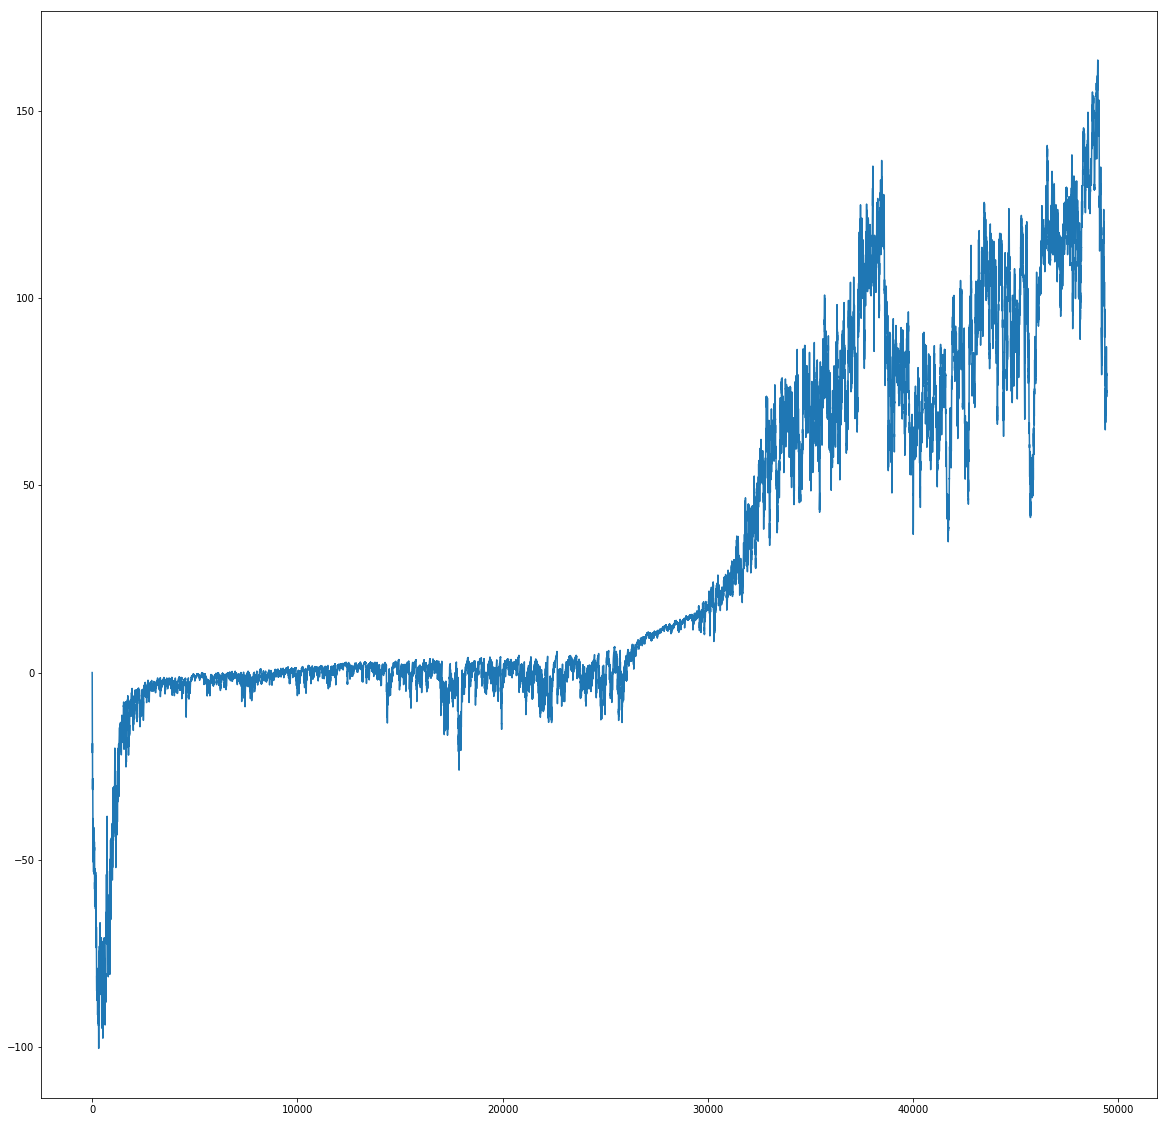

In [3]:
with open("./save_graph/scores.txt", 'r') as storage:
    data = list(map(float, storage.readline().split()))

from matplotlib import pylab

fig = pylab.figure(figsize=(20, 20))
pylab.plot(range(len(data)), data)
pylab.show()
pylab.close()


Видео ходьбы в прикреплении рядом с письмом

## Выводы

RMSProp лучше для таких задач

Возможно мое второе решение тоже рабочее, просто я брал слишком большой learning rate

Я не понимаю как можно хорошо обучиться за 800 итераций( 